In [1]:
using QuantumBayesian
using PyPlot
using Pkg

# Single Qubit Evolution Tests

**Justin Dressel**, 12/6/2016 <br />
*Institute for Quantum Studies, Chapman University*

Benchmark various integration algorithms for a single qubit damped Rabi oscillation, for comparison with the DifferentialEquations package tested in a separate notebook.

## Basic Definitions

### Qubit Hilbert space

In [2]:
q = qubit()

QFactor: Qubit
Dims  : 2
Ops   : 'x', 'd', 'i', 'u', 'y', 'z'


### Global Constants

In [3]:
Ω  = 2*π;        # Rabi frequency
τ = 3.0;         # Measurement collapse timescale
Γ = 1/(2*τ);     # Measurement dephasing rate (quantum-limited efficiency)
T = (0.0, 6*τ);  # Time duration of simulation;

dt = 1e-2;       # Simulation timestep (coarse to show method precision);

### Common Trajectory and Plotting Code

In [4]:
# Initial conditions (matrix and superket)
init = ground(q)
sinit = superket(init)

# Bloch expectation values (matrix and superket)
fs  = collect(ρ -> real(expect(ρ, q(l))) for l in ['x','y','z'])
sfs = collect(ρ -> real(expect(unsuperket(ρ),q(l))) for l in ['x','y','z'])

# Trajectory and plotting function
function solve(inc, init, dt, T, fs, plot_title; readout=false, n=1)
    figure(1)
    if n==1
        out = trajectory(inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = trajectory(inc, init, T, fs..., dt=dt)
        plot(out[1].t,out[1],label=L"$x$",color="r")
        hold(true)
        plot(out[2].t,out[2],label=L"$y$",color="g")
        plot(out[3].t,out[3],label=L"$z$",color="b")
        hold(false)
    else
        out = ensemble(1, inc, init, (0.0, 0.1), fs..., dt=dt, points=10, verbose=false) #JIT throw-away
        @time out = ensemble(n, inc, init, T, fs..., dt=dt)
        m1 = mean(out[1]); m2 = mean(out[2]); m3 = mean(out[3]);
        s1 = std(out[1]); s2 = std(out[2]); s3 = std(out[3]);
        plot(out[1].t,m1,label=L"$x$",color="r")
        hold(true)
        plot(out[2].t,m2,label=L"$y$",color="g")
        plot(out[3].t,m3,label=L"$z$",color="b")
        fill_between(out[1].t, m1-s1, m1+s1, color="r", alpha=0.2, antialiased=true)
        fill_between(out[2].t, m2-s2, m2+s2, color="g", alpha=0.2, antialiased=true)
        fill_between(out[3].t, m3-s3, m3+s3, color="b", alpha=0.2, antialiased=true)
        hold(false)
    end
    ax = gca()
    ax[:set_ylim]([-1.1,1.1])
    xlabel(L"$t (2\pi/\Omega)$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    hold(false)
    show()
    if readout
        figure(2)
        if n==1
            plot(out[4].t,out[4],label=L"$r_z$",color="k")
        else
            m4 = mean(out[4]); s4 = std(out[4]); 
            plot(out[4].t,m4,label=L"$r_z$",color="k")
            hold(true)
            fill_between(out[4].t, m4-s4, m4+s4, color="k", alpha=0.2, antialiased=true)
            hold(false)
        end
        xlabel(L"$t (2\pi/\Omega)$")
        ylabel("Stochastic readout")
        title(plot_title*" Readout")
        legend()
        show()
    end
end;

## Time-independent Rabi Hamiltonian

In [5]:
# Hamiltonian
H = (Ω/2)*q('y');
# Measurement dephasing
DM = sqrt(Γ/2)*q('z');
# Stochastic monitoring (unit efficiency)
SM = [(q('z'), τ, 1.0)];

### Coherent (Hamiltonian) Evolution

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.013761043548583984
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 130804.03340379085
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


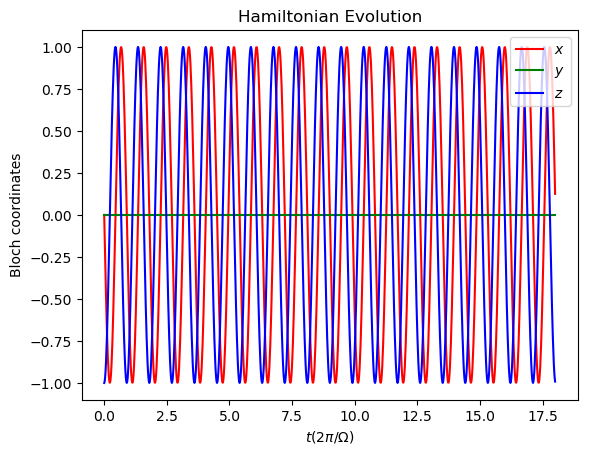

  0.977391 seconds (643.52 k allocations: 35.140 MiB, 2.00% gc time)


In [6]:
solve(ham(dt, H), init, dt, T, fs, "Hamiltonian Evolution")

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.005424976348876953
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 331798.6815504966
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


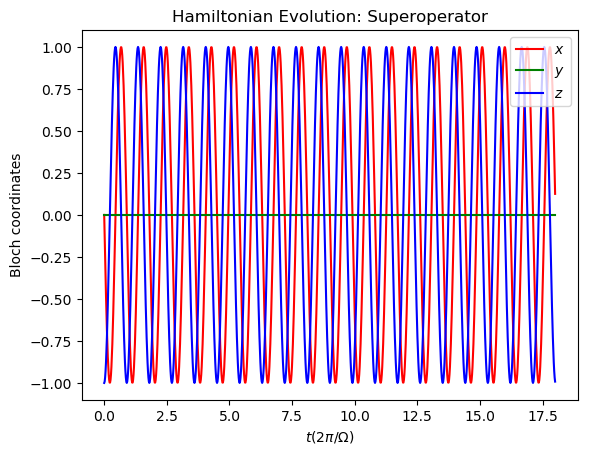

  0.021971 seconds (44.97 k allocations: 2.261 MiB)


In [7]:
solve(sham(dt, H), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.06356000900268555
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 28319.6939119997
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


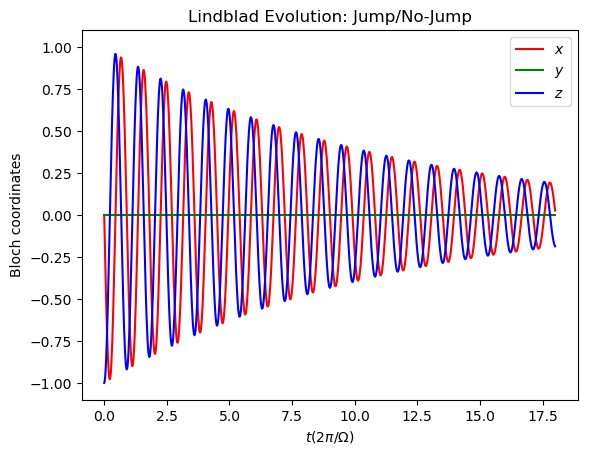

  0.065383 seconds (302.75 k allocations: 28.433 MiB, 16.47% gc time)


In [8]:
solve(lind(dt, H, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.005635976791381836
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 319376.7587461399
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


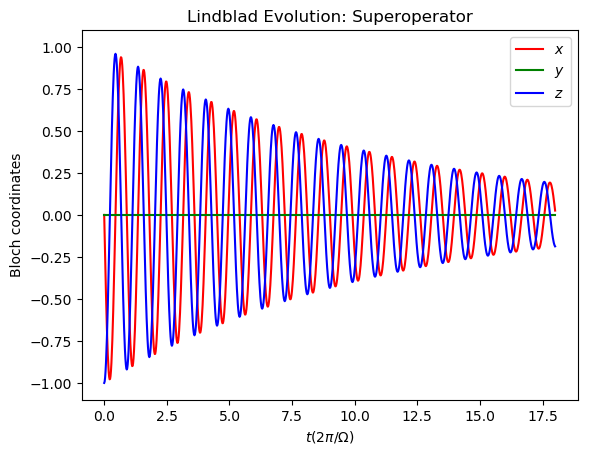

  0.006204 seconds (88.89 k allocations: 6.136 MiB)


In [9]:
solve(slind(dt, H, clist=[DM]), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.10829496383666992
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 16621.271536825607
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


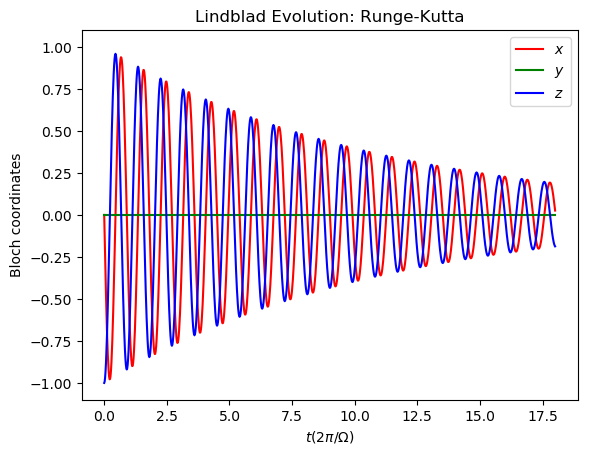

  0.108923 seconds (1.31 M allocations: 118.392 MiB, 20.80% gc time)


In [10]:
solve(lind_rk4(dt, H, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

### Stochastic (Monitored) Evolution

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:549
┌ Info: Time elapsed: 
│   elapsed = 0.0492250919342041
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 36566.71687695251
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


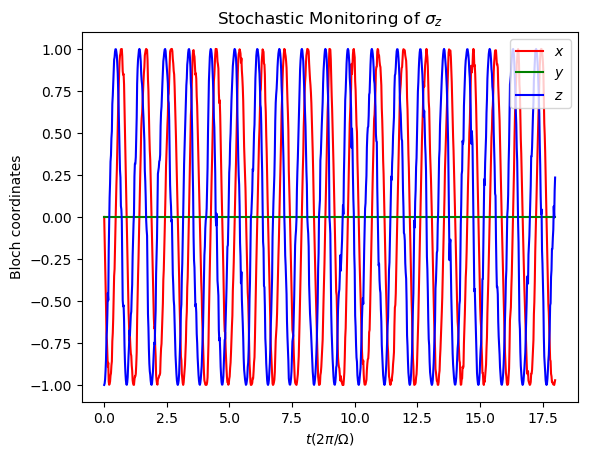

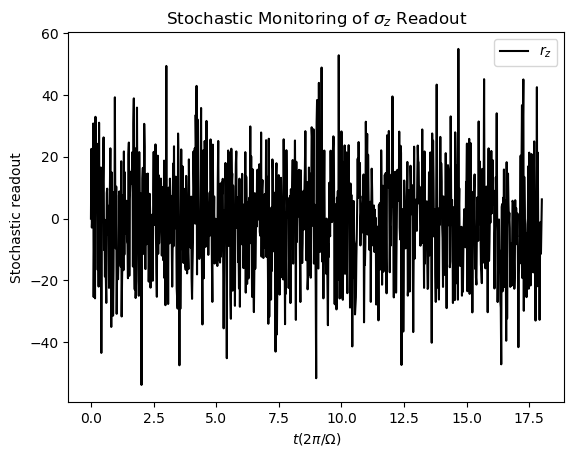

  0.124781 seconds (400.91 k allocations: 30.108 MiB, 4.36% gc time)


In [11]:
solve(meas(dt, H, mclist=SM), init, dt, T, fs, L"Stochastic Monitoring of $\sigma_z$", readout=true)

(Note: no parallelization performed here to benchmark serial execution of an ensemble simulation. Plotted is the mean with shaded standard deviation behind.)

┌ Info: Trajectories: 
│   n = 2500
│   , steps each:  = , steps each: 
│   N = 1799
│   , points each:  = , points each: 
│   min(N, points) = 1000
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:472
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:475


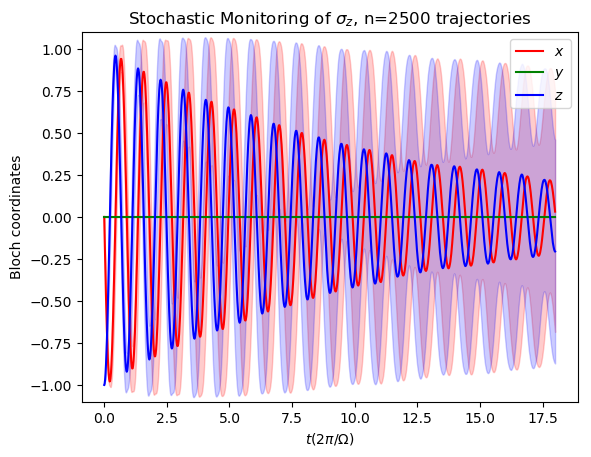

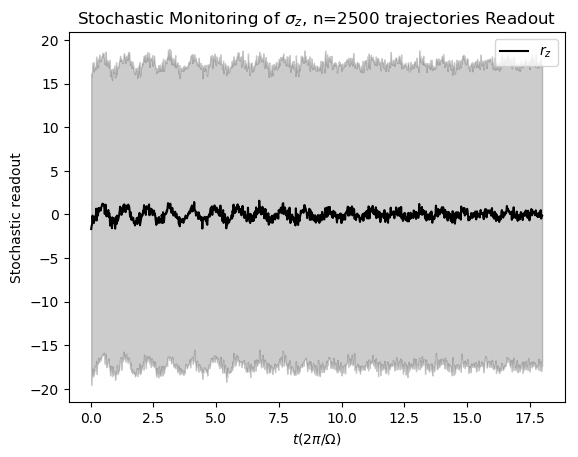

199.404772 seconds (706.67 M allocations: 58.449 GiB, 5.08% gc time)


┌ Info: Time elapsed: 
│   elapsed = 198.7786889076233
│    s, Steps:  =  s, Steps: 
│   steps = 2500000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 12576.800932426933
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:493


In [12]:
solve(meas(dt, H, mclist=SM), init, dt, T, fs, L"Stochastic Monitoring of $\sigma_z$, n=2500 trajectories", readout=true, n=2500)

## Time-dependent Rabi Pulse

In [13]:
# Hamiltonian
f(t::Float64) = 2*exp(-(t-3*τ)^2/2)/sqrt(2π)
h(t::Float64) = f(t)*(Ω/2)*q('y');

### Coherent (Hamiltonian) Evolution

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.04106497764587402
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 43832.97162663508
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


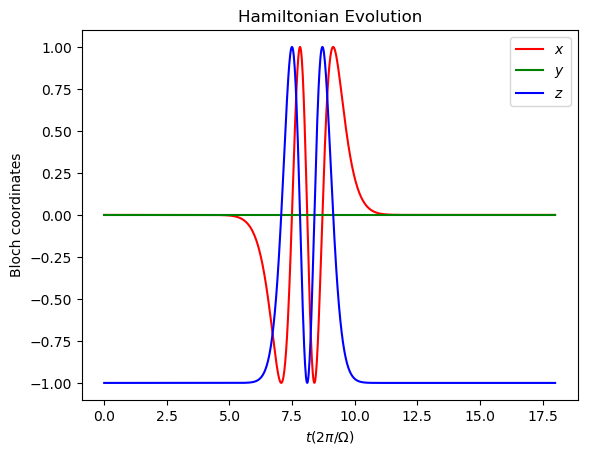

  0.042149 seconds (196.28 k allocations: 15.264 MiB)


In [14]:
solve(ham(dt, h), init, dt, T, fs, "Hamiltonian Evolution")

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.045588016510009766
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 39484.060457089065
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


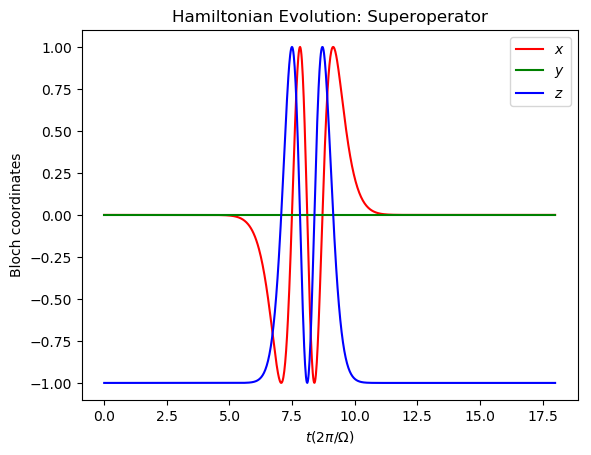

  0.047172 seconds (162.37 k allocations: 13.056 MiB, 14.86% gc time)


In [15]:
solve(sham(dt, h), sinit, dt, T, sfs, "Hamiltonian Evolution: Superoperator")

### Dissipative (Lindblad) Evolution

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.061517953872680664
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 29259.75079934115
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


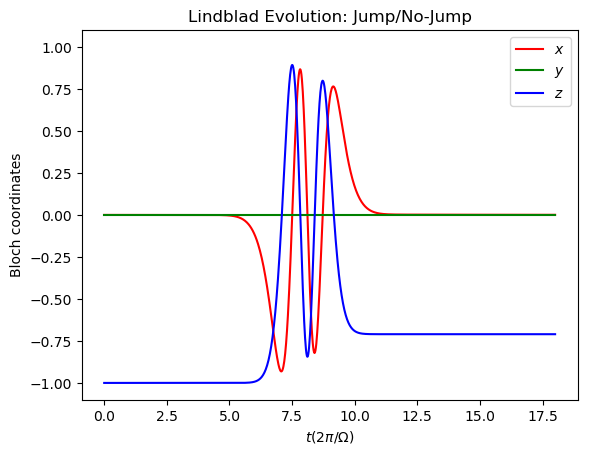

  0.062280 seconds (402.21 k allocations: 36.009 MiB, 17.40% gc time)


In [16]:
solve(lind(dt, h, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Jump/No-Jump")

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.1328418254852295
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 13549.949298160915
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


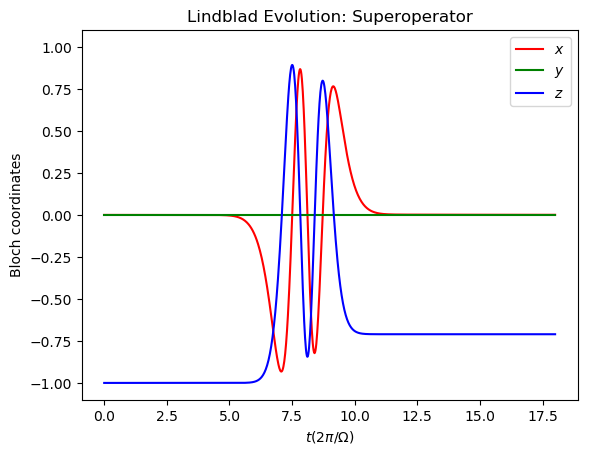

  0.133955 seconds (331.19 k allocations: 42.882 MiB, 10.54% gc time)


In [17]:
solve(slind(dt, h, clist=[DM]), sinit, dt, T, sfs, "Lindblad Evolution: Superoperator")

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Time elapsed: 
│   elapsed = 0.1757040023803711
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 10244.50197840848
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


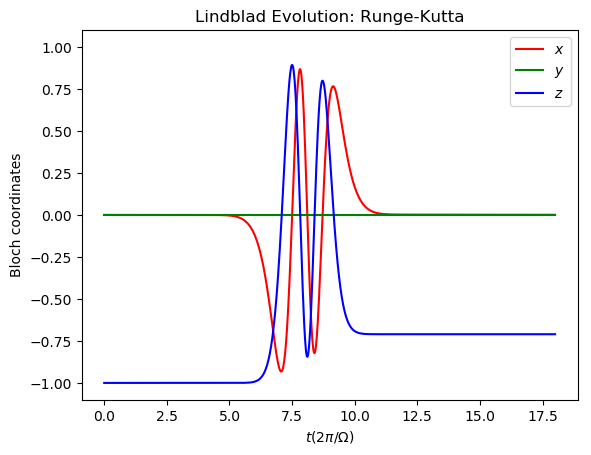

  0.176696 seconds (1.44 M allocations: 122.788 MiB, 15.73% gc time)


In [18]:
solve(lind_rk4(dt, h, clist=[DM]), init, dt, T, fs, "Lindblad Evolution: Runge-Kutta")

### Stochastic (Monitored) Evolution

┌ Info: Trajectory: steps = 
│   N - 1 = 1800
│   , points =  = , points = 
│   Ns = 1000
│   , values =  = , values = 
│   Nf = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:548
┌ Info: Readout: values = 
│   Nr = 1
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:549
┌ Info: Time elapsed: 
│   elapsed = 0.13628315925598145
│    s, Steps per second:  =  s, Steps per second: 
│   (N - 1) / elapsed = 13207.794784233389
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:566


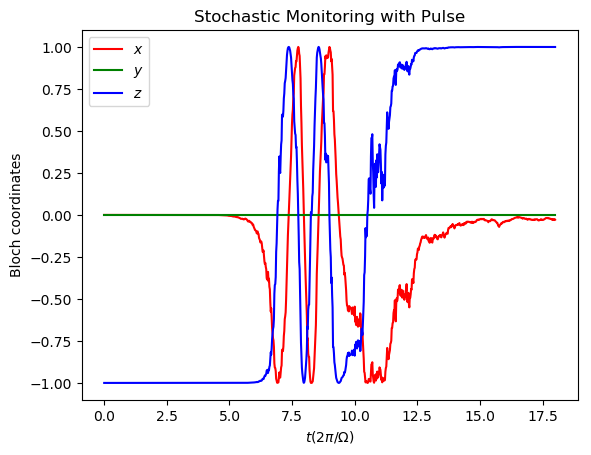

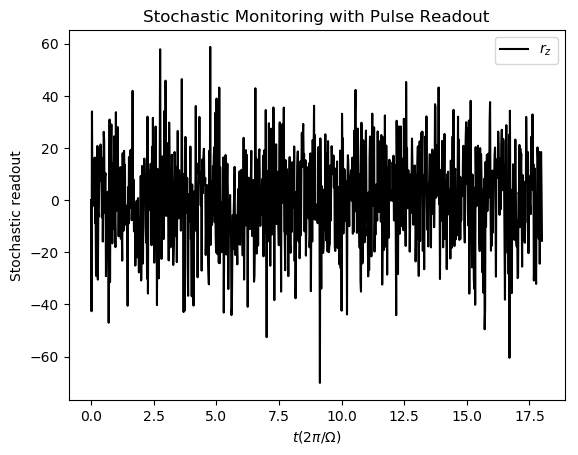

  0.137872 seconds (382.40 k allocations: 31.559 MiB, 13.53% gc time)


In [19]:
solve(meas(dt, h, mclist=SM), init, dt, T, fs, "Stochastic Monitoring with Pulse", readout=true)

┌ Info: Trajectories: 
│   n = 2500
│   , steps each:  = , steps each: 
│   N = 1799
│   , points each:  = , points each: 
│   min(N, points) = 1000
│   , values each =  = , values each = 
│   length(fs) = 3
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:472
┌ Info: Readouts: values each = 
│   length(pinit) - 1 = 1
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:475


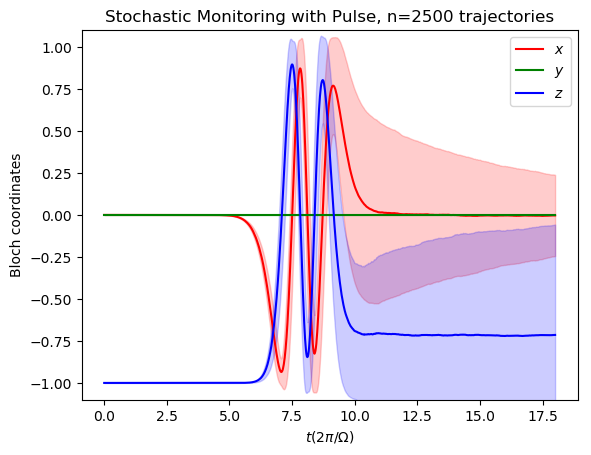

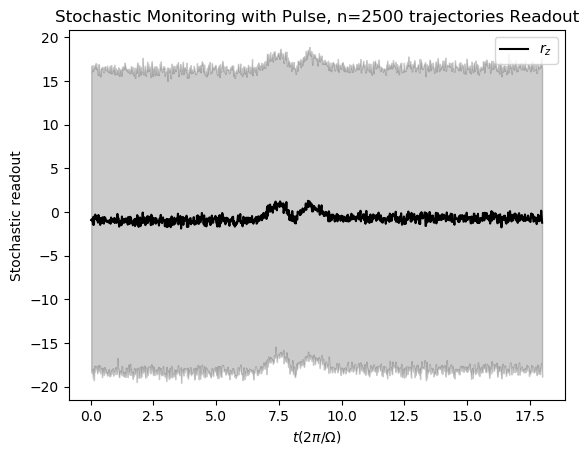

578.676833 seconds (954.42 M allocations: 76.898 GiB, 2.65% gc time)


┌ Info: Time elapsed: 
│   elapsed = 578.4621257781982
│    s, Steps:  =  s, Steps: 
│   steps = 2500000
│   , Steps per second:  = , Steps per second: 
│   steps / elapsed = 4321.804122675758
└ @ QuantumBayesian /Users/joseraul/.julia/dev/QuantumBayesian/src/QuantumEvolution.jl:493


In [20]:
solve(meas(dt, h, mclist=SM), init, dt, T, fs, "Stochastic Monitoring with Pulse, n=2500 trajectories", readout=true, n=2500)

## Version Information

In [21]:
versioninfo()

Julia Version 1.0.0
Commit 5d4eaca0c9 (2018-08-08 20:58 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.0 (ORCJIT, haswell)


In [22]:
Pkg.installed()["PyPlot"]

v"2.6.0"

In [25]:
Pkg.installed()["Interpolations"]

v"0.8.0"

In [24]:
Pkg.installed()["QuantumBayesian"]

v"0.3.0"